In [54]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
from scipy.stats import norm, poisson,moment,bernoulli
from scipy.integrate import quad
import scipy.special
import scipy.integrate
from scipy.stats import linregress
from scipy.interpolate import interp1d

import math
import random


In [55]:
@jit(nopython=False)
def ecosystem(N,S,h,k,mu,sigma,tmax,dt,T,init,alpha):
    x = np.zeros((N,tmax,S))
    for i in range(N):
        x[i][0] = init#np.random.rand(S) #+ init
        for t in range(0,tmax-1):
            dx = dt*x[i][t]*(h - k*x[i][t]
                                + (np.dot(alpha,x[i][t,:])))
            + np.sqrt(dt)*T*np.random.randn(S) + 10**(-9)

            x[i][t+1] = x[i][t] + dx
            #for sp in range(S):
            #    if x[i][t+1,sp] < 10**(-6):
            #        #print('gotcha')
            #       x[i][t+1,sp] = 0
    return x

def timeevo(t,x,alpha,sys):
    x[x<0]=0
    if sys =='linear':
        y = (1 - x + (np.dot(alpha,x))) + 10**(-10)
    elif sys=='glv':
        y = x*(1 - x + (np.dot(alpha,x))) + 10**(-10)
    elif sys=='linsat':
        y = (1 - x + (np.dot(alpha,x/(1+x)))) + 10**(-10)
    elif sys=='glvsat':
        y = x*(1 - x + (np.dot(alpha,x/(1+x)))) + 10**(-10)
    elif sys=='glv_carcap':
        y = x*(1 - 3*x + (np.dot(alpha,x))) + 10**(-10)
    return y


def solver_t(tmax,IC,alpha,sys,dt=1):
    sol = scipy.integrate.solve_ivp(timeevo, [0, tmax], IC,args=[alpha,sys], method='LSODA',t_eval=np.multiply(range(tmax),dt))
    return sol.y


    

In [104]:
def timeevo_dmft(t,x,eta):
     return  x*(1-x+eta[t])

def NGdmft(N,tmax,S,init,lamda,beta,dt,T):
    x = np.zeros([N,tmax,S])
    eta = np.zeros([N+1,tmax,S])
    x[:,0] = init
    eta[0] = beta*x[0]*poisson.rvs(lamda,size=[tmax,S])#+0.0001
    for i in range(N):
        #y= scipy.integrate.solve_ivp(timeevo_dmft, [0, tmax],init,args=[eta[i]], method='LSODA',t_eval=range(tmax)).y
        x[i][0] = init#np.random.rand(S) #+ init
        for t in range(0,tmax-1):
            dx = dt*x[i][t]*(1-x[i][t] + eta[i][t])
            + np.sqrt(dt)*T*np.random.randn(S) + 10**(-10)

            x[i][t+1] = x[i][t] + dx
        #print(np.shape(y))
        meanx = np.zeros([tmax,S])
        meanx.T[:] = np.mean(x[i],axis=1)
        #for t in range(0,tmax):
        #    for j in range(S):
        #        eta[i+1][t][j] = meanx[t] * beta*poisson.rvs(lamda)
        eta[i+1] = np.multiply(meanx, beta*poisson.rvs(lamda,size=[tmax,S]))
                #np.multiply(np.mean(x[i],axis=1),beta*poisson.rvs(lamda,size=[tmax]))
        #beta*x[i,t]*poisson.rvs(lamda,size=[S])
        #random.shuffle(eta[i+1][t+1])
    return x,eta
init= np.random.rand(500)
DMFTx , DMFTeta= NGdmft(40,2500,500,init,0.2,0.1,0.01,0)


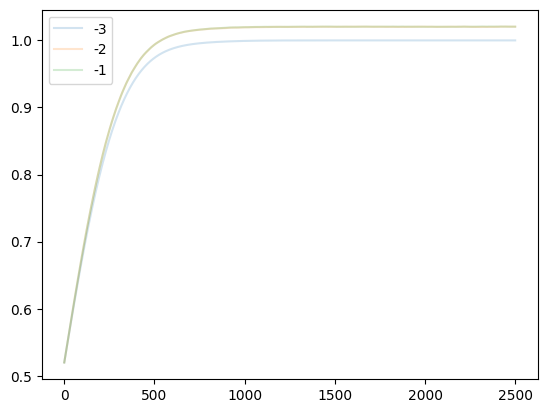

In [105]:
#print(np.shape(DMFTx[-1]))
plt.plot(np.mean(DMFTx[0],axis=1),label='-3',alpha=0.2)

plt.plot(np.mean(DMFTx[-2],axis=1),label='-2',alpha=0.2)

plt.plot(np.mean(DMFTx[-1],axis=1),label='-1',alpha=0.2)
#plt.plot(np.mean(DMFTx1[-1],axis=1),label='-1 ah',alpha=0.2)

plt.legend()
#print(DMFTx)

In [126]:
# N,S,h,k,mu,sigma . chaos (-4 1)
N = 1
S =700
sys='glv'

lamda= 1.1
beta =1.1
mu= 0
q= 1# - 0.85* 1/(lamda*np.exp(-lamda)*S) #1 is all positive, 0 is all negative
gamma= -0.5
sigma=0
tmax=50000
dt = 0.01

p  = 2*(bernoulli.rvs(q,size=[S,S])-0.5)
print(np.shape(p))
alpha = np.multiply(p,beta*poisson.rvs(lamda/S,loc=mu/S,size=[S,S]))+gamma/S +np.random.randn(S,S)*sigma/np.sqrt(S)

np.fill_diagonal(alpha,0)
T=0
nudge= 0.001
IC1 =np.random.rand(S)+0.001
#x1= ecosystem(N,S,h,k,mu,sigma,tmax,dt,T,IC1,alpha)
#y1 = ecosystem(N,S,h,k,mu,sigma,tmax,dt,T,IC1+0.001*np.random.choice([1,-1],S),alpha)

# tmax, dt, T
#example = Ecosystem(10,1,1,10,10,1)
#sol = example.evolve(100,0.1)

(700, 700)


In [6]:
def selfcon(lamda,beta,R,x0):
    if q==0:
        phi = np.zeros(R) + np.exp(-lamda)
        x = np.zeros(R)+np.exp(-lamda)
        #x[0]=x0
        for i in range(1,R):
            #print(1/(np.abs(beta)*x[i-1]))
            for j in range(1,int(1/(np.abs(beta)*x[i-1]))):
                phi[i]+= lamda**j/math.factorial(j)*np.exp(-lamda)
                x[i]+= lamda**j/math.factorial(j)*np.exp(-lamda)*(1-beta*j*x[i-1])
                #print(x[i],phi[i])
        return phi[-1],x[-1]
    elif q==1:
        return 1, 1/(1-beta*lamda)
    else:
        print('ambiguous sign of beta')

def extinct_prop(lamda,beta,q):
    extent= int(700)
    thresh = 0
    def thresh(i):
        return  int(np.floor(0.5*(i-(1-lamda*beta*(2*q-1))/beta))) # upper bound for j depends on i

    def summand(i, j):
        return np.exp(-lamda)*lamda**i*q**j*(1-q)**(i-j)/(scipy.special.factorial(j)*scipy.special.factorial(i-j))  # your function of i and j

    total = 0
    for i in range(extent):
        for j in range(thresh(i)):
            total += summand(i, j)
    return total #- scipy.special.lambertw(lamda)/lamda

#phi, M = selfcon(lamda,beta,10,0.9)
qs = np.linspace(0,1,20)
phi_0 = 0#extinct_prop(lamda,beta,q)
meandivcrit = lamda*beta*(2*q-1)-1
variancedivcrit = lamda*beta**2-1
chaoscrit = (1-phi_0)*lamda*beta**2-1 #positive for instability (or divergent variance)
print(meandivcrit,variancedivcrit)
print(phi_0,np.real(1-scipy.special.lambertw((1-2*q)*lamda)/(lamda*(1-2*q))),chaoscrit)

-0.4522774424948339 0.0
0 -0.631340757267383 0.0


In [47]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
def func_cos(x, c):
    return np.exp(-c*x) -x

crange = range(1, 11)
res = root(func_cos, 0.5, args=(lamda, ))
print(res.x)
phi=res.x


[0.61258482]


C:\Users\User\AppData\Local\Temp\ipykernel_10688\1424016075.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cphi[i] = cspace[i]*root(func_cos, 0.5, args=(cspace[i], )).x
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1424016075.py:6: RuntimeWarning: divide by zero encountered in divide
  tau= 1/cphi


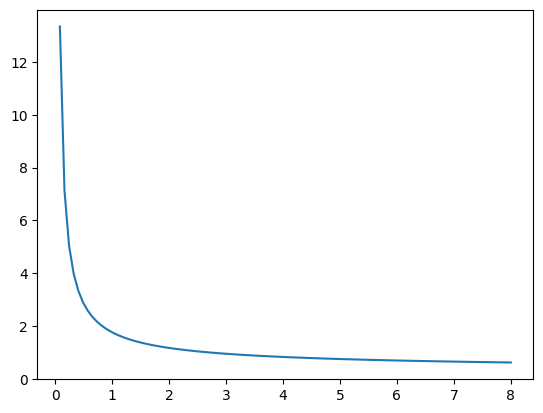

In [53]:

cspace = np.linspace(0,8,100)
cphi= np.zeros(len(cspace))
for i in range(len(cspace)):
    cphi[i] = cspace[i]*root(func_cos, 0.5, args=(cspace[i], )).x
#betaspace= 1+np.exp(-1/cphi)
tau= 1/cphi  
plt.plot(cspace,tau)
#plt.xlim(-2,0)

In [ ]:
def single(R,x20):
    x2_k = x20
    zero =0.00001# 0.0001
    for i in range(R):
        norm_k = beta*np.sqrt(x2_k)*quad(lambda x:poisson.pmf(x-1,lamda,mu*np.sqrt(x2_k)),zero,np.inf)[0]
        #x0_k = quad(lambda x:x*P_k(x-1,delta,mu*x2_k,beta*np.sqrt(x2_k)),zero,np.inf)[0]/norm_k
        print(norm_k)
        x2_k = (beta*np.sqrt(x2_k)*quad(lambda x:x*poisson.pmf(x-1,lamda,mu*np.sqrt(x2_k)),zero,np.inf)[0]/norm_k)**2 #- x0_helper**2
        if x2_k<0:
            x2_k=0.1
        if i==R-2:
            x0_k= np.sqrt(x2_k)
            pair1 = [x0_k,x2_k]
        print(f'x2_k = {x2_k}')
    x0_k= np.sqrt(x2_k)
    pair2 = [x0_k,x2_k]
    return pair1,pair2
spair1,spair2= single(20,0.5)


In [ ]:
def single_linear(R,x20):
    x1_k = x20
    zero =0.00001# 0.0001
    inf = 100
    for i in range(R):
        norm_k = beta*x1_k*np.sum(poisson.pmf(np.arange(0,  100),lamda,))
        print(norm_k)
        #x0_k = quad(lambda x:x*P_k(x-1,delta,mu*x2_k,beta*np.sqrt(x2_k)),zero,np.inf)[0]/norm_k
        x1_k = (beta*x1_k*np.sum(np.arange(0,inf)*poisson.pmf(np.arange(0,  inf),lamda,))/norm_k) #- x0_helper**2
        if x1_k<0:
            x1_k=0.1
        if i==R-2:
            pair1 = x1_k
        print(f'x1_k = {x1_k}')

    return pair1,x1_k
spair1,spair2= single_linear(20,0.4)

In [ ]:
def F_poisson(x,c,beta,cumulants):
    return c*(np.exp(-1j*beta*x*cumulants[1])-1)

def F_poisson2(x,c,beta,cumulants):
    return c*(np.exp(1j*beta*x*cumulants[1]-beta**2/2 *cumulants[2]*x**2)-1)

def glv_finddist(func,n,L,shift):
    #x0_temp=1
    #x2_temp=1
    cumulants = np.zeros(3)+1
    for j in range(10):
        space = np.linspace(-L,L,n)
        inputs=np.zeros(n)
        for i in range(n):
            inputs[i] = func(space[i],lamda,beta,cumulants)
        
        outputs =2*L*(np.fft.fftshift(np.abs(np.fft.fft(inputs,))) )/(n*2*np.pi)
        
        f = np.fft.fftshift(np.fft.fftfreq(n,2*L/n))
        lowerlim = n//2-int(shift*(1+mu*cumulants[1]))
        #upperlim = 
        cumulants[0] = scipy.integrate.simps(outputs[lowerlim:],f[lowerlim:]*2*np.pi)
        cumulants[1] = scipy.integrate.simps((1+mu*cumulants[1]+(f[lowerlim:]*2*np.pi))*outputs[lowerlim:],f[lowerlim:]*2*np.pi)/cumulants[0]
        cumulants[2] = scipy.integrate.simps((1+mu*cumulants[1]+(f[lowerlim:]*2*np.pi)-cumulants[1])**2*outputs[lowerlim:],f[lowerlim:]*2*np.pi)/cumulants[0]
        print(f'norm, cumulants = {cumulants} ')

    print(f'norm is {cumulants[0]}')
    extinct = scipy.integrate.simps(outputs[:lowerlim],f[:lowerlim]*2*np.pi)
    print(f'extinct is {extinct}')
    #outputs = np.fft.fft(inputs,1000)
    return outputs/cumulants[0], space,inputs,f, cumulants#/moments[0]#,x0_temp,x2_temp
n = 50000
L = 1000
frs = np.fft.fftshift(np.fft.fftfreq(n,2*L/n))
shift_0 = (2*np.pi)**(-1)/(frs[n//2+1]-frs[n//2])
o,s,i,f,c= glv_finddist(F_poisson,n,L,shift=shift_0)
o2,s2,i2,f2,c2= glv_finddist(F_poisson2,n,L,shift=shift_0)

In [ ]:
tm=700
dt=0.1
IC =0.05*np.random.rand(S)#init#[np.mean(init) for i in range(S)]#np.random.rand(S)+0.1
#alpha = beta*poisson.rvs(lamda/S,loc=mu/S,size=[S,S])

#alpha = np.multiply(p,beta*bernoulli.rvs(lamda/S,size=[S,S]))
np.fill_diagonal(alpha,0)
x3 = solver_t(tm,IC,alpha,sys,dt=dt)

#IC2 = IC+np.random.choice([1,-1],size=S)*0.1
#y2 = solver_t(tm,IC2,alpha,sys)

C:\Users\User\AppData\Local\Temp\ipykernel_22708\1621286019.py:23: RuntimeWarning: overflow encountered in multiply
  y = x*(1 - x + (np.dot(alpha,x))) + 10**(-10)
c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


C:\Users\User\AppData\Local\Temp\ipykernel_22708\4193289887.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv',N)


4.036196289272625


Text(0.5, 1.0, 'poisson c=1.1, beta=1.1,q=1 ')

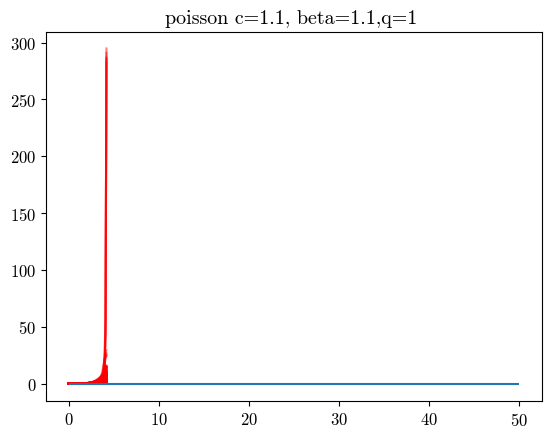

In [128]:
cmap = plt.cm.get_cmap('hsv',N)
for j in range(N):
    for i in range(S):
        #plt.plot(y1[j].T[i][::100],color='blue',alpha=0.5)
        #plt.plot(x1[j].T[i][::100],color='red',alpha=0.5)
        #plt.plot(y2[i],color='blue',alpha=0.5)
        plt.plot(np.multiply(range(tm),dt)[:len(x3[i])],x3[i],color='red',alpha=0.5)
        #plt.plot(z[i],color=cmap(j),alpha=0.5)
print(np.mean(x3.T[-1]))
#print(M)
#plt.ylim(0,29)
plt.hlines(1+gamma/(1-(gamma+lamda*beta)),0,50)
xf = x3.T[-1]
plt.title(f'poisson c={lamda}, beta={beta},q={q} ')
#plt.xlim(0,10)

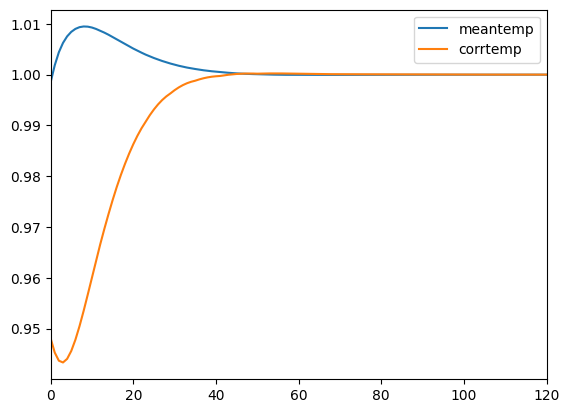

In [51]:
def tempcorrs(x,tm,S,label=''):
    dev = np.zeros([S,tm])
    corr =np.zeros([S,tm])
    for i in range(S):
        dev[i] = x[i]-x[0]
        corr[i] = dev[i]**2
    cor= np.absolute(np.mean(dev,axis=0))
    men = np.mean(corr,axis=0)
    plt.plot(men/men[-1],label='mean'+label)
    plt.plot(cor/cor[-1],label='corr'+label)
    plt.legend()
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(0,120)
tempcorrs(x3,tm,S,'temp')
#tempcorrs(x1dot1,tm,S)

0.0 -0.5


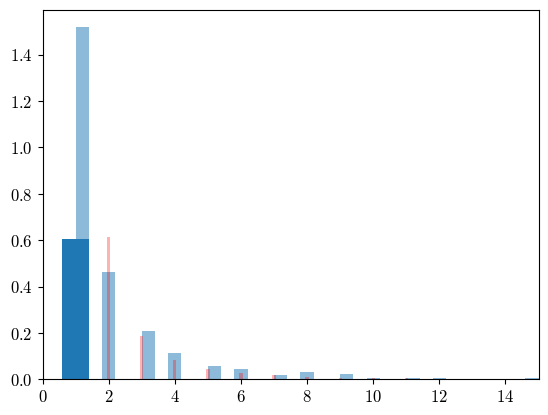

In [ ]:
def srv(last):
    srv =[]
    dead = []
    for i in range(len(last)):
        if last[i] > 10e-6 and last[i]<10e100:
            if not np.isnan(last[i]):
                srv.append(last[i])
        else:
            dead.append(last[i])
    empirical_extinct= len(dead)/len(last)
    empirical_stabcrit = (1-empirical_extinct)*lamda*beta**2-1
    print(empirical_extinct,empirical_stabcrit)
    #print(1-phi)
    return srv
final = srv(x3.T[-50])
plt.hist(final,density=True,alpha=0.5,bins=40,label='sol 1');

zero=1
x_k = np.array(range(1,100))#np.linspace(0,5,6)
y_k = np.zeros([len(x_k)])
#norm_k = quad(lambda x:beta*np.sqrt(spair2[1])*poisson.pmf(x-1,lamda,mu*spair1[1],),zero,np.infty)[0]
#y_k = beta*np.sqrt(spair2[1])*poisson.pmf(x_k-1,lamda,mu*spair1[1])/norm_k
#norm_k = quad(lambda x:poisson.pmf(x-1,lamda),zero,np.infty)[0]
#beta= -beta
beta_prime = beta/(1-beta*lamda)
norm = beta*(1+lamda*beta_prime)
#y_k = poisson.pmf((x_k),lamda)#/newmean#/norm_k
r= lamda-1-np.log(lamda)
#
#y_k= np.exp(x_k*(-r)/beta)/(lamda*(x_k*r/beta)**(3/2))

y_k = (lamda *np.exp(-lamda))**(x_k)*(x_k)**(x_k-1)/(scipy.special.factorial(x_k))
#plt.yscale('log')
#np.append(x_k,1)
#np.append(y_k,np.exp(lamda))
#plt.xscale('log')
#plt.bar(1+x_k*beta_prime,y_k/norm,width=0.1,alpha=0.3,color='red')
plt.bar(1+x_k,y_k/np.sum(y_k),width=0.1,alpha=0.3,color='red')
plt.bar(1,np.exp(-lamda))
#plt.plot(f2+1,o2)
#plt.ylim(0,9)
plt.xlim(0,15)
#plt.xlim(-0.01,20)
#print(beta)
#plt.vlines(1/(1+lamda*beta),0,4)
plt.show()

In [53]:
print(sum(2.2<i <3.2  for i in final))
print(58/700)
np.exp(-3*lamda)*lamda**2*3/2

58
0.08285714285714285


0.08367381005566119

In [ ]:
plt.plot(np.linspace(0,49999,500),np.mean(x3,axis=0),alpha=0.2,label='glv')
plt.plot(np.mean(DMFTx[-1],axis=1),label='dmft',alpha=0.2,)
plt.xlabel('time')
plt.ylabel('mean abundance')
plt.title('mean trajectory compared with DMFT. sparse c=0.2,beta=0.1')
plt.legend()
plt.xlim(0,1000)

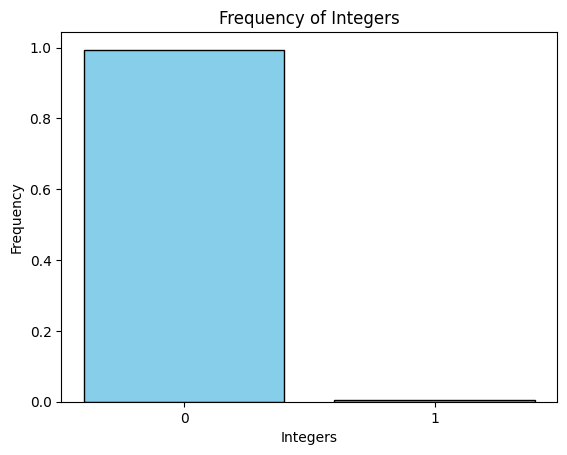

In [295]:
from collections import Counter

# Given array
data = final

# Count the frequency of each integer
frequency = Counter(np.array(data).astype(int))

# Separate keys and values for plotting
keys = list(frequency.keys())
values = list(frequency.values())
plt.bar(keys, np.divide(values,S), color='skyblue', edgecolor='black')
plt.xlabel('Integers')
plt.ylabel('Frequency')
plt.title('Frequency of Integers')
plt.xticks(keys)  # Ensure all keys are shown on x-axis
plt.show()

In [62]:
values[1]

951

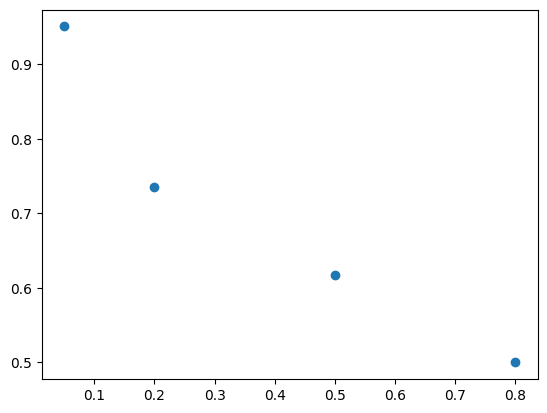

In [63]:
plt.scatter([0.05,0.2,0.5,0.8],[0.951,0.736,0.618,0.5])

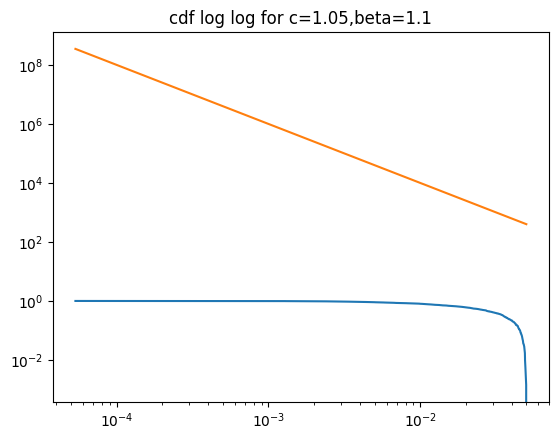

In [8]:
def cumuldensity(srv):
    data_sorted = np.sort(srv)

    # calculate the proportional valu?es of samples
    p = 1. * np.arange(len(srv)) / (len(srv) - 1)
    #plt.plot(data_sorted,p,drawstyle='steps-post')
    #plt.plot(data_sorted,p)
    #df = f[n//2]-f[n//2-1]

    #plt.plot(data_sorted)
    return p,data_sorted
cumulative_1= cumuldensity(final)
plt.plot(cumulative_1[1],1-cumulative_1[0])
plt.plot(cumulative_1[1],1/cumulative_1[1]**2)
plt.yscale('log')
plt.xscale('log')
plt.title(f'cdf log log for c={lamda},beta={beta}')
beta1p2 = cumulative_1

In [113]:
until = 1650
slope, intercept, r_value, p_value, std_err = linregress(np.log(cumulative_1[1])[until:-1],np.log(1-cumulative_1[0])[until:-1])
print(f"Slope: {slope}, Intercept: {intercept}")

Slope: -1.7995501264804468, Intercept: -0.14818786408113294


C:\Users\User\AppData\Local\Temp\ipykernel_7888\2232859049.py:2: RuntimeWarning: divide by zero encountered in log
  slope, intercept, r_value, p_value, std_err = linregress(np.log(cumulative_1[1])[until:-1],np.log(1-cumulative_1[0])[until:-1])


In [9]:
def cdfs_powers1(delta, betas,S,tmax,Runs):
    #xs= np.zeros([len(betas),S,tmax])
    cdfs= np.zeros([len(betas),Runs*S])
    commons= np.zeros([len(betas),Runs*S])
    for i in range(len(betas)):
        all_data=[]
        for j in range(Runs):
            interactions = betas[i]*poisson.rvs(delta/S,loc=0/S,size=[S,S]) #np.random.choice([-1, 1], size=(S, S))
            np.fill_diagonal(interactions,0)
            IC  = np.random.rand(S)
            xs = solver_t(tmax,IC,interactions,sys='glv');
            if xs.shape== (S,tmax):
                data = srv(xs.T[-1])
                all_data.extend(data)
                print(all_data)
            else:
                print(xs.shape)
            print(max(interactions.flatten()))
        #print(np.shape(cdf_runs))
        cd=  cumuldensity(all_data)
        cdfs[i][:len(cd[1])]=cd[1]
        commons[i][:len(cd[0])]=cd[0]
        #plt.hist(xs[i].T[-1])
    return cdfs,commons
S=1000
runs=1
tm= 500
delta= 0.3
betas = [delta**(-1/1.5),delta**(-1/2)]#[delta**(-1/1.5),delta**(-1/2),delta**(-1/2.5),delta**(-1/3),delta**(-1/3.5),delta**(-1/4),delta**(-1/4.5)]#[0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]
cdfs,commons  =cdfs_powers1(delta,betas,S,tm,runs)

0.0 0.2705000000000002
[1.0000000000999991, 3.231443167194625, 1.0000000000999996, 1.0000000001, 1.0000000000999991, 1.0000000000999996, 1.0000000001, 1.0000000000999698, 1.0000000000999996, 1.0000000001, 5.462886334345722, 1.0000000000999831, 1.0000000001, 1.0000000000999996, 3.2314431671946524, 1.0000000001, 8.210781774805463, 1.0000000000999991, 1.0000000000999996, 1.0000000000999938, 1.0000000001, 1.0000000001, 8.21078177480547, 3.231443167194646, 1.0000000000999996, 1.0000000001, 8.210781774805467, 1.0000000000999951, 1.0000000000999996, 1.0000000000999982, 1.0000000001, 1.0000000001, 1.0000000000999858, 3.2314431671946555, 1.0000000000999991, 1.0000000001, 8.210781774805456, 1.0000000000999991, 8.21078177480547, 3.231443167194654, 1.0000000001, 1.000000000099956, 1.0000000001, 1.0000000000999996, 1.0000000001, 1.0000000001, 1.0000000000999996, 5.462886334345717, 3.231443167194655, 51.32648762903433, 3.2314431671946546, 1.0000000000999996, 3.231443167194623, 1.0000000001, 1.000000

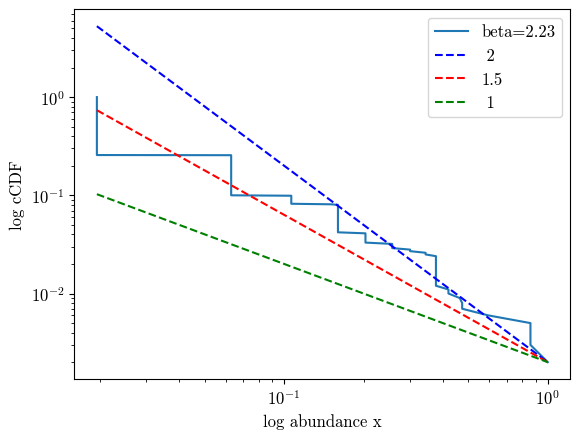

In [10]:
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True
})
fromlimit = 0
tolimit= runs*S-2
match = -1
for_fits = np.zeros([len(betas),2,tolimit-fromlimit])
for i in [0]:#range(len(betas)):
    #plt.plot(yep[i][1]/max(yep[i][1]),(1-yep[i][0])/max((1-yep[i][0])),label=betas[i])
    #plt.plot(yep[i][1],(1-yep[i][0]),label=np.round(betas[i],2))
    x_data = cdfs[i][fromlimit:tolimit] / max(cdfs[0][fromlimit:tolimit])
    y_data = (1 - commons[i][fromlimit:tolimit]) / max(1 - commons[0][fromlimit:tolimit]) 
    plt.plot(x_data, y_data, label=f'beta={np.round(betas[i], 2)}')
    for_fits[i] = [x_data, y_data]
    xs = x_data  # same xs
    p=1.5+1
    p=np.round(-np.log(delta)/np.log(betas[i]),1)
    ys_model = 1 / xs**(p)
    ys_model = ys_model / max(ys_model)  # normalize

    # Scale so that the last point matches
    scale_factor = y_data[match] / ys_model[match]
    ys_model_scaled = ys_model * scale_factor
    #np.savetxt(f'plot_data_exp{p}.csv',y_data,delimiter=',')
    plt.plot(xs, ys_model_scaled*xs**(-0.5), linestyle='dashed', label=f' {2}',color='blue')

    plt.plot(xs, ys_model_scaled, linestyle='dashed', label=f'{1.5}',color='red')
    plt.plot(xs, ys_model_scaled*xs**(0.5), linestyle='dashed', label=f' {1}',color='green')



plt.yscale('log')
plt.xscale('log')
plt.xlabel('log abundance x')
plt.ylabel('log cCDF')
#plt.title(f'log log of complement of CDF of x delta={delta}')
plt.legend()


In [45]:
print(len(x_data))

100


In [31]:
cdfs.shape

(100,)

In [ ]:
statss = np.zeros([len(betas),2])
for i in range(len(betas)):
    statss[i][0], statss[i][1], r_value, _, _ = linregress(np.log(for_fits[i][0][:-1]), np.log(for_fits[i][1][:-1]))


[[-14.11006104  -1.79027126]
 [ -6.4816442   -1.5370462 ]
 [ -4.82961386  -1.36751254]
 [ -4.17428979  -1.77372119]
 [ -2.45589337  -1.43399925]
 [ -0.86311523  -1.42221631]
 [ -2.0896001   -1.52363024]
 [ -1.71167167  -1.41120168]
 [ -1.59363036  -1.44114722]
 [ -1.2033187   -1.27377369]]


Text(0, 0.5, 'power law of cdf')

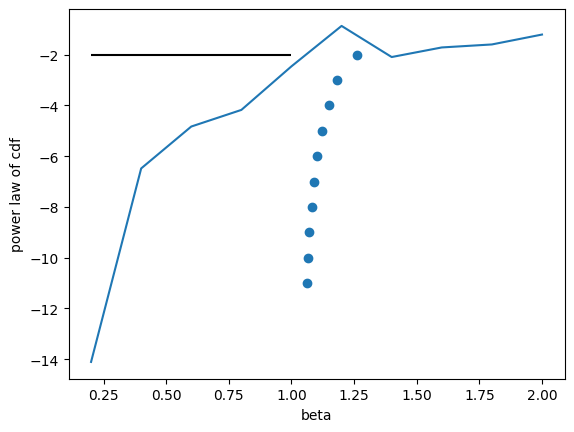

In [42]:
plt.plot(betas,statss.T[0])
sl1 = linregress(np.log(p2[fromlimit:tolimit]/max(p2)),np.log(1-p1[fromlimit:tolimit]))[0]
plt.hlines(sl1,.2,1,color='black',label='predicted gamma')
plt.scatter([1.06,1.065,1.07,1.08,1.09,1.10,1.12,1.15,1.18,1.26],[-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]) # delta=0.5
#plt.scatter([1.06,1.065,1.07,1.08,1.09,1.10,1.12,1.15,1.18,1.26],[-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]) # delta=0.2

print(statss)
plt.xlabel('beta')
plt.ylabel('power law of cdf')

In [15]:
log_x = np.log(beta1[1]/max(beta1[1]))[750:-1]
log_P_x = np.log((1-beta1[0]))[750:-1]
slope, intercept, r_value, _, _ = linregress(log_x, log_P_x)
alpha= 1-slope
plt.scatter(log_x, log_P_x, label="Data")
plt.plot(log_x, slope * log_x + intercept, color='red', label=f"Fit: alpha={alpha}")
plt.legend()

NameError: name 'beta1' is not defined

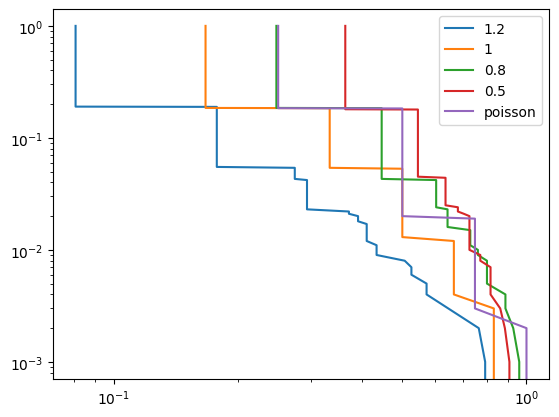

In [117]:
plt.plot(beta1p2[1]/max(beta1p2[1]),(1-beta1p2[0]),label='1.2')

#plt.plot(beta1p1[1]/max(beta1p1[1]),(1-beta1p1[0]),label='1.1')

plt.plot(beta1[1]/max(beta1[1]),(1-beta1[0]),label='1')
plt.plot(beta0p8[1]/max(beta0p8[1]),(1-beta0p8[0]),label='0.8')

plt.plot(beta0p5[1]/max(beta0p5[1]),(1-beta0p5[0]),label='0.5')
plt.plot(p2/max(p2),1-p1,label='poisson')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [112]:
print(np.mean(x2[:,-1]))
#plt.hist(jacob)

2.4521171343387804e+90


In [9]:
LYlambdas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
LYgmus=[0]#[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0]#[-5,-4,-3,-2.5,-2,-1.5,-1.2,-1,-0.8,-0.5,-0.2,-0.1,0,0.1,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5]
LYS = [50,350]
LYNs= [1,2,3,4,5,6,7,13,14,15,17,18]
LYbetas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
LYks = [1,2,3,4]
divs_orig = np.zeros([len(LYNs),len(LYlambdas),len(LYbetas),len(LYS)])
exps = np.zeros([len(LYNs),len(LYlambdas),len(LYbetas),len(LYS)])
cumuls = np.zeros([len(LYNs),len(LYlambdas),len(LYbetas),len(LYS),len(LYks)])

for LYN in range(len(LYNs)):
    divs_orig[LYN] = np.loadtxt(f'data/divs_glv_poisson_{LYNs[LYN]}_1000_b{LYbetas[0]}.csv',delimiter=',').reshape([1,len(LYlambdas),len(LYbetas),len(LYS)])
    exps[LYN] = np.loadtxt(f'data/exps_glv_poisson_{LYNs[LYN]}_1000_b{LYbetas[0]}.csv',delimiter=',').reshape([1,len(LYlambdas),len(LYbetas),len(LYS)])
    cumuls[LYN] = np.loadtxt(f'data/cumuls_glv_poisson_{LYNs[LYN]}_1000_b{LYbetas[0]}.csv',delimiter=',').reshape([1,len(LYlambdas),len(LYbetas),len(LYS),4])

#evals=  np.loadtxt(f'data/evals_poisson_{LYN}_b{LYbeta}.csv',delimiter=',').reshape([LYN,len(LYlambdas),len(LYS),2])

Text(0.5, 1.0, 'proportion of divergences for poisson glv, S=350 ')

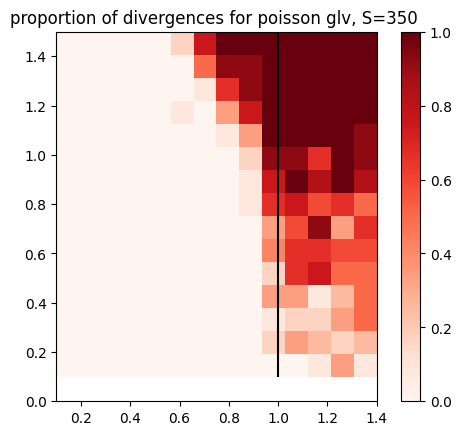

In [137]:
#plt.plot(LYS,np.nanmean(exps,0)[1,:])
divs = np.zeros([len(LYS),len(LYlambdas),len(LYgmus)])
divs = np.sum(np.isnan(divs_orig),axis=0)#+np.sum(divs_orig>100,axis=0) + np.sum(divs_orig<-100,axis=0)

#plt.plot(LYbetas,evals[0,0,:,0,1])
#plt.xlabel('S')
#plt.ylabel('diverging prop')
#plt.hlines(0,0,5,color='black')
#plt.vlines(np.sqrt(2),-0.02,0.01,color='red',label='sigma crit')
#plt.vlines(2.5,-0.02,0.01,color='green',label='divergence')
#plt.plot(LYS,[16/20,17/20,19/20,13/20],label='lambda = 0.8')
#plt.plot(LYS,divs[0,0,:]/LYN,label=f'lambda={LYlambdas[0]}, beta={LYbetas[0]}')
#plt.plot(LYS,divs[0,1,:]/LYN,label=f'lambda={LYlambdas[0]}, beta={LYbetas[1]}')
#plt.plot(LYS,divs[1,0,:]/LYN,label=f'lambda={LYlambdas[1]}, beta={LYbetas[0]}')
#plt.plot(LYS,divs[1,1,:]/LYN,label=f'lambda={LYlambdas[1]}, beta={LYbetas[1]}')
#print(divs[0,0])
#plt.plot(LYS,[18/20,20/20,19/20,20/20],label='lambda = 1.1')
plt.imshow(divs[:,:,1]/len(LYNs),cmap='Reds',origin='lower',extent=[LYbetas[0],LYbetas[-1],LYlambdas[0],LYlambdas[-1]])

bets = np.linspace(LYbetas[0],LYbetas[-1],100)
dels = 1/(bets)
dels2 = 1/np.power(bets,4)

plt.vlines(1,LYlambdas[0],LYlambdas[-1],color='black')
#plt.plot(bets,dels,color='black')
plt.ylim(0,1.5)
#plt.legend()
plt.colorbar()
#plt.title(f'lyapunov exponent at time 900 for initial perturbation 0.001, S={LYS} ')
plt.title(f'proportion of divergences for poisson glv, S=350 ')
#print(sum(exps))


In [35]:
np.shape(cumuls)

(12, 15, 14, 2, 4)

C:\Users\User\AppData\Local\Temp\ipykernel_3844\3969230420.py:1: RuntimeWarning: Mean of empty slice
  exps_mean = np.nanmean(exps,axis=0)


Text(0.5, 1.0, 'global lyapunov exponent for poisson glv, S=350 ')

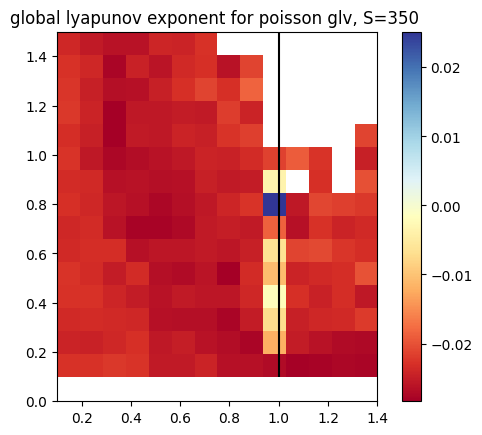

In [138]:
exps_mean = np.nanmean(exps,axis=0)
plt.imshow(exps_mean[:,:,1],cmap='RdYlBu',origin='lower',extent=[LYbetas[0],LYbetas[-1],LYlambdas[0],LYlambdas[-1]])

bets = np.linspace(LYbetas[0],LYbetas[-1],100)
dels = 1/(bets)
#dels2 = 1/np.power(bets,4)

plt.vlines(1,LYlambdas[0],LYlambdas[-1],color='black')
#plt.plot(bets,dels,color='black')
plt.ylim(0,1.5)
#plt.legend()
plt.colorbar()
#plt.title(f'lyapunov exponent at time 900 for initial perturbation 0.001, S={LYS} ')
plt.title(f'global lyapunov exponent for poisson glv, S=350 ')

C:\Users\User\AppData\Local\Temp\ipykernel_3844\4271999738.py:1: RuntimeWarning: Mean of empty slice
  cumuls_mean = np.nanmean(cumuls,axis=0)


Text(0.5, 1.0, 'cumulant for poisson glv, S=350 ')

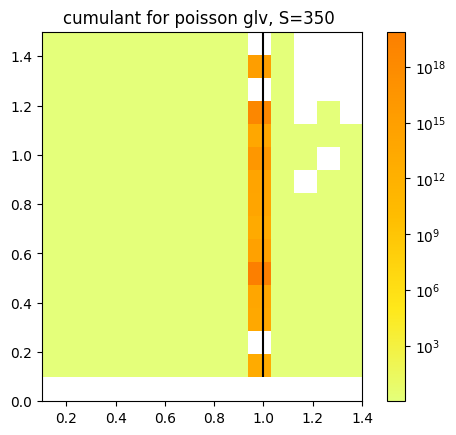

In [145]:
cumuls_mean = np.nanmean(cumuls,axis=0)
plt.imshow(cumuls_no10[:,:,0,1],cmap='Wistia',norm='log',origin='lower',extent=[LYbetas[0],LYbetas[-1],LYlambdas[0],LYlambdas[-1]])

bets = np.linspace(LYbetas[0],LYbetas[-1],100)
dels = 1/(bets)
#dels2 = 1/np.power(bets,4)
cumuls_no10 = cumuls_mean
cumuls_no10[:,10,:,:] = np.zeros([])
plt.vlines(1,LYlambdas[0],LYlambdas[-1],color='black')
#plt.plot(bets,dels,color='black')
plt.ylim(0,1.5)
#plt.legend()
plt.colorbar()
#plt.title(f'lyapunov exponent at time 900 for initial perturbation 0.001, S={LYS} ')
plt.title(f'cumulant for poisson glv, S=350 ')

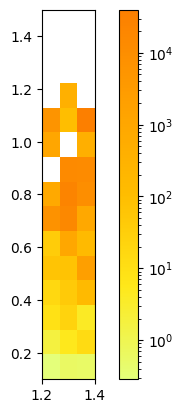

In [149]:
plt.imshow(cumuls_mean[:,11:,0,3],cmap='Wistia',norm='log',origin='lower',extent=[LYbetas[11],LYbetas[13],LYlambdas[0],LYlambdas[-1]])
plt.colorbar()
np.shape(cumuls_mean)
eg = cumuls

In [93]:
trajs_350 = np.loadtxt('data/trajs_glv_poisson_13_1000_350.csv',delimiter=',').reshape([len(LYlambdas),len(LYbetas),350,1000])

In [96]:
finals = trajs_350[:,:,:,-1]

[           nan 4.97974183e+01 9.52578455e+04 2.88629631e+08]


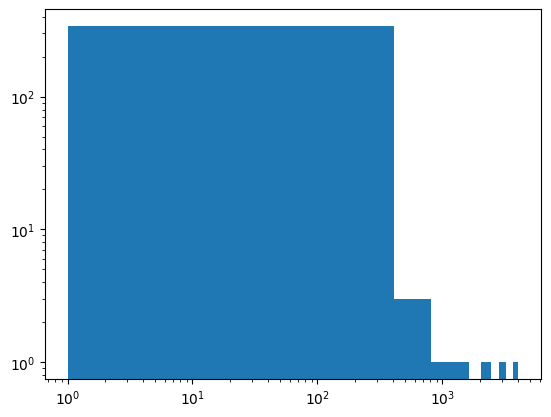

In [153]:
plt.hist(finals[7,-1])
plt.xscale('log')
plt.yscale('log')
#plt.imshow(np.nanmean(finals,axis=2),origin='lower',cmap='Reds',norm='log')
#plt.colorbar()
print(cumuls[7,7,-1,1])

In [14]:
run = np.zeros([LYN,len(LYlambdas),len(LYbetas),len(LYS)])
cumuls = np.zeros([LYN,len(LYlambdas),len(LYbetas),len(LYS),4])
def cumulant(x,p):
    if p ==1:
        return np.mean(x)
    elif p==2:
        return np.var(x)
    elif p==3:
        return moment(x,3)
    elif p==4:
        return moment(x,4)-3*np.var(x)**2

for l in range(LYN):
    for i in range(len(LYlambdas)):
        for k in range(len(LYbetas)):
            for j in range(len(LYS)):
                guy = np.loadtxt(f'data/divs_linear_poisson_20_1000_{l}_{i}_{j}_{k}.csv',delimiter=',')
                for w in range(1,5):
                    cumuls[l,i,k,j,w-1] = cumulant(guy.T[-1],w)

np.savetxt(f'data/cumuls_linear_poisson_20_1000_b{LYbetas[0]}.csv',cumuls.reshape([LYN,len(LYlambdas)*len(LYbetas)*len(LYS)*4]),delimiter=',')



c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\scipy\stats\_stats_py.py:1076: RuntimeWarning: overflow encountered in square
  s = s**2
C:\Users\User\AppData\Local\Temp\ipykernel_21196\1430146191.py:11: RuntimeWarning: overflow encountered in scalar power
  return moment(x,4)-3*np.var(x)**2
C:\Users\User\AppData\Local\Temp\ipykernel_21196\1430146191.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  return moment(x,4)-3*np.var(x)**2
c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\scipy\stats\_stats_py.py:1078: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

[2.00048213e+00 3.77452184e+85 2.95629803e+85 6.25220463e+85
 3.30544847e+85 2.66093486e+00 2.44589585e+00 2.29034752e+00
 1.50912917e+85 3.95873168e+85 3.13926090e+85 2.32915132e+00
 2.43148903e+85 3.47901000e+00 3.13032031e+86 3.02208713e+00
 8.27744822e+85 2.20526933e+00 2.36451925e+00 2.53017536e+00]


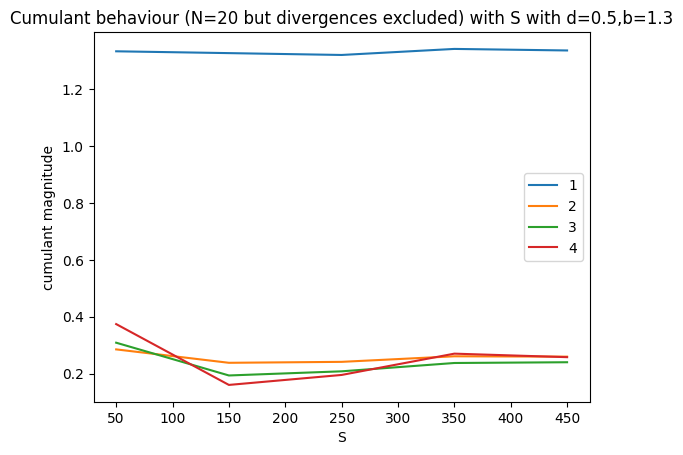

In [48]:

#cumuls1 = np.ma.array (cumuls[:,:,:,:,0], mask=nans_mask)
print(cumuls[:,0,1,-1,0])
maskmask = np.where(cumuls>1000,np.nan,cumuls)
maskmaskmask = np.where(cumuls<-1000,np.nan,maskmask)

#cumuls1 = np.ma.array(cumuls,mask=maskmask)
for i in range(4):
    plt.plot(LYS,np.nanmean(maskmaskmask[:,0,0,:,i],axis=0),label=i+1)
#for i in range(2,4):
#    plt.plot(LYS,np.nanmean(cumuls[:,0,0,:,i],axis=0),label=i+1)
plt.title(f'Cumulant behaviour (N=20 but divergences excluded) with S with d={LYlambdas[0]},b={LYbetas[2]}')
plt.xlabel('S')
plt.ylabel('cumulant magnitude')
plt.legend()

C:\Users\User\AppData\Local\Temp\ipykernel_21196\3677965104.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = plt.imshow(divs[:,:,1]/LYN,cmap='Reds',interpolation=None,extent=[LYlambdas[0],LYlambdas[-1],LYbetas[0],LYbetas[-1]],origin='lower')


Text(0, 0.5, 'delta')

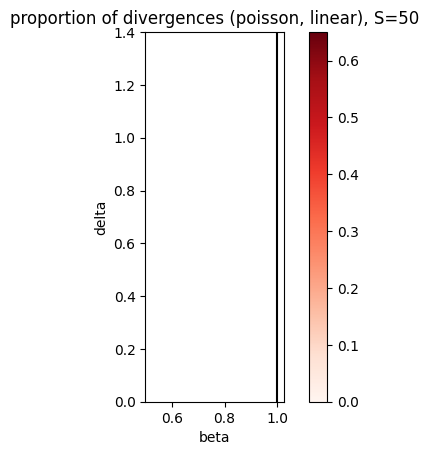

In [29]:
np.shape(divs)
gradient = divs[:,:,1]- divs[:,:,0]

im = plt.imshow(divs[:,:,1]/LYN,cmap='Reds',interpolation=None,extent=[LYlambdas[0],LYlambdas[-1],LYbetas[0],LYbetas[-1]],origin='lower')
plt.vlines(1,0,1.4,color='black')
bets = np.linspace(LYlambdas[0],LYlambdas[-1],100)
dels = 1/(bets**2)
dels2 = 1/np.power(bets,4)

plt.plot(bets,dels,color='black')
#plt.plot(bets,dels2,color='black')

plt.ylim(0,1.4)
plt.colorbar()
plt.title('proportion of divergences (poisson, linear), S=50')
plt.xlabel('beta')
plt.ylabel('delta')

0.10044884081378254
False


Text(0.5, 1.0, 'avg # pos eval for div')

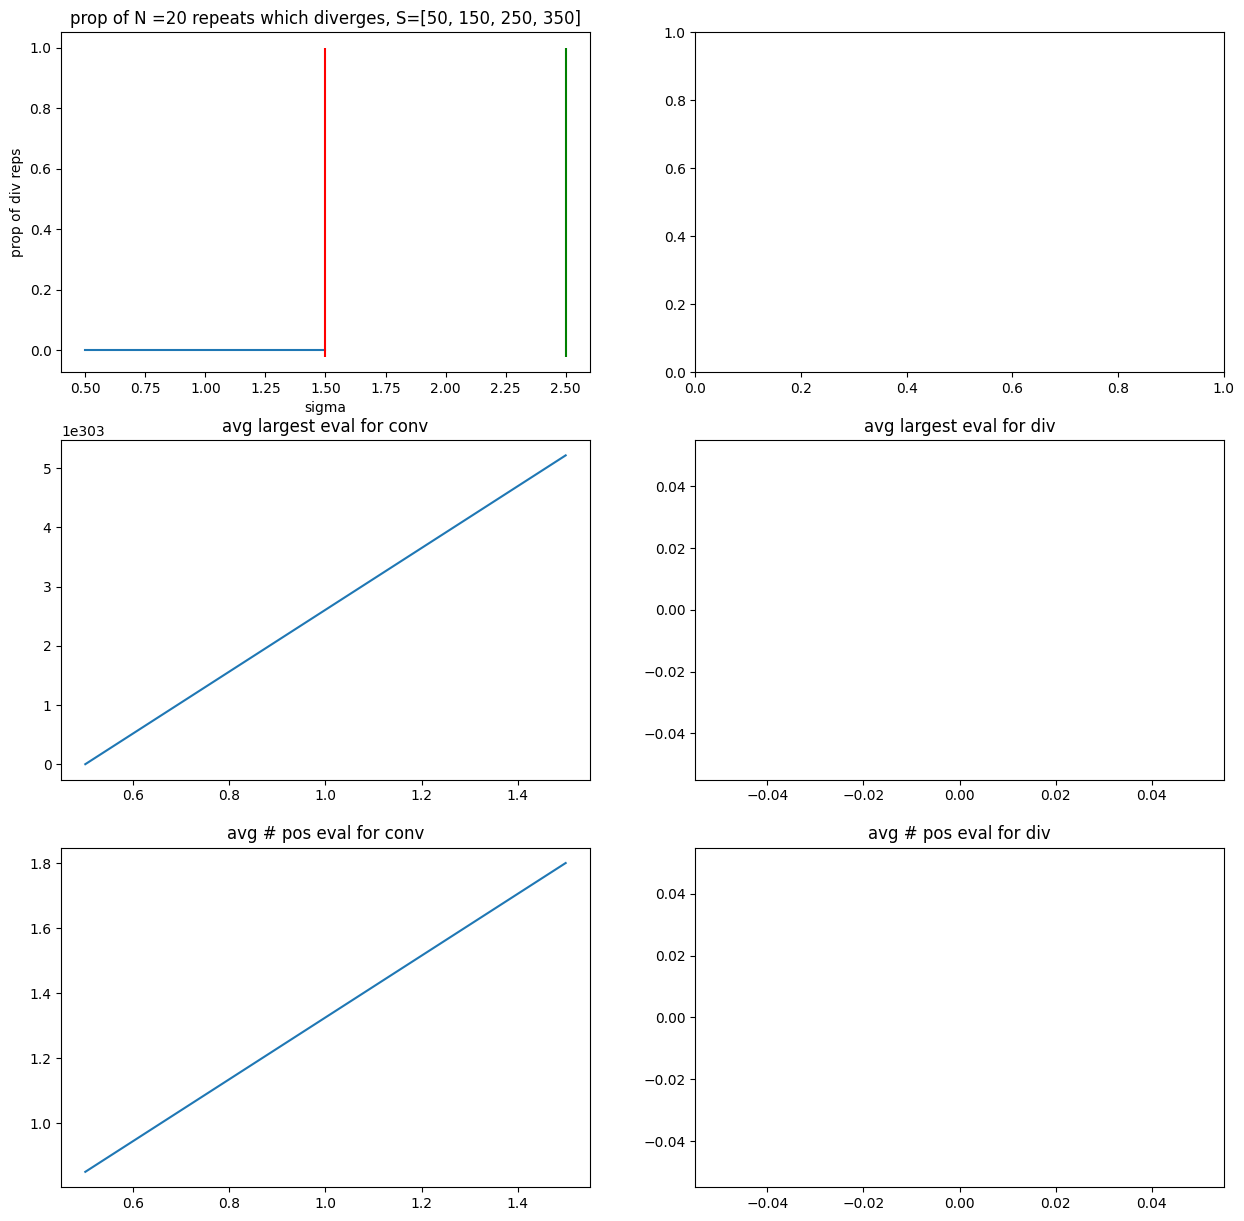

In [100]:
nans= np.count_nonzero(np.isnan(exps),axis=0)
fig,axs =plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)
nans_mask = np.isnan(exps)
div_evals1 = np.ma.array (evals[:,:,:,0], mask=~nans_mask)
conv_evals1 = np.ma.array (evals[:,:,:,0], mask=nans_mask)
div_evals2 = np.ma.array (evals[:,:,:,1], mask=~nans_mask)
conv_evals2 = np.ma.array (evals[:,:,:,1], mask=nans_mask)
axs[0,0].plot(LYlambdas,nans[:,0]/LYN)
print(exps[0,0,0])
print(nans_mask[0,0,0])
axs[0,0].set_xlabel('sigma')
axs[0,0].set_ylabel('prop of div reps')
axs[0,0].set_title(f'prop of N ={LYN} repeats which diverges, S={LYS}')
axs[0,0].vlines(2.5,-0.02,1,color='green',label='divergence')
axs[0,0].vlines(1.5,-0.02,1,color='red',label='critical')

axs[1,0].plot(LYlambdas,np.nanmean(conv_evals1,axis=0)[:,0])
axs[1,0].set_title(f'avg largest eval for conv')

axs[1,1].plot(LYlambdas,np.nanmean(div_evals1,axis=0)[:,0])
axs[1,1].set_title(f'avg largest eval for div')

axs[2,0].plot(LYlambdas,np.nanmean(conv_evals2,axis=0)[:,0])
axs[2,0].set_title(f'avg # pos eval for conv')

axs[2,1].plot(LYlambdas,np.nanmean(div_evals2,axis=0)[:,0])
axs[2,1].set_title(f'avg # pos eval for div')


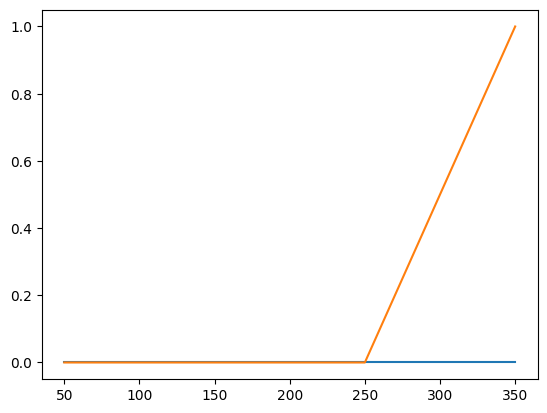

In [101]:
plt.plot(LYS,nans[0,:])
plt.plot(LYS,nans[1,:])

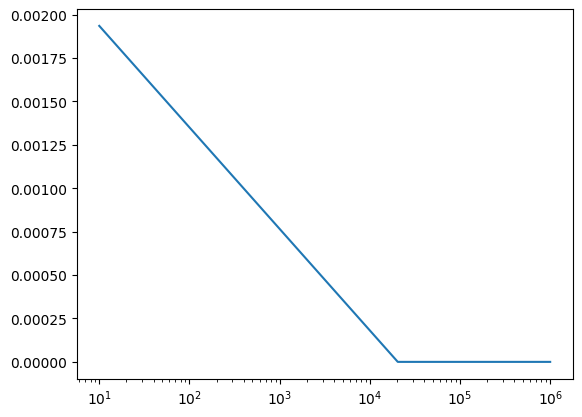

In [58]:
S1 = np.linspace(10,10e5,50)

d=0.9
m=-0.1
b=0.9
guys =np.zeros([50])
for i in range(50):
    guys[i] = quad(lambda x:S1[i]*norm.pdf(x,m/S1[i],b/np.sqrt(S1[i])),1,np.infty)[0]

plt.plot(S1,guys)
plt.xscale('log')

In [ ]:
for i in range(N):
    plt.hist(x=alphas.flatten(),bins=20,edgecolor='black',density=True,alpha=0.1);
x_points = np.linspace(mu/S-3*sigma/np.sqrt(S),mu/S+3*sigma/np.sqrt(S),200)
def gaussian(x_point):
    return np.sqrt(S)/(sigma*np.sqrt(2*np.pi))*np.exp(-S*(x_point-mu/S)**2/(2*sigma**2))
y_points = gaussian(x_points)
plt.plot(x_points,y_points)
plt.show()

In [ ]:
for i in range(N):
    plt.hist(x[i][-1,:],alpha=0.1, bins = 20)
#plt.vlines(x,ymin=0,ymax=20)

In [15]:
a=[[1,2,3],[3,4,5]]
b=[[2,3,4],[5,6,7]]
np.add(a[0],b[0])**2
print(x1.shape)


(1, 80000, 800)


0.01

In [29]:
def lyapunov(x,y,dt): # two trajectories with close initial conditions
    tm = len(x)
    val = np.zeros(tm-1)
    for i in range(1,tm-1):
        val[i] = 1/(2*i*dt)*np.log(np.sum(np.subtract(x[i],y[i])**2)/np.sum(np.subtract(x[0],y[0])**2))
    return val
#lya_solver = lyapunov(x2.T,y2.T,dt=1)
#lya_euler = lyapunov(x1[0],y1[0],dt=dt)

#plt.plot(lya_solver)
#print(lya_solver[-1])


In [30]:
def lyapunov_line(S,tm,mu,sigmas,nudge):
    #x2= np.zeros([len(sigmas),S,tm])
    #y2= np.zeros([len(sigmas),S,tm])
    exps = np.zeros([len(sigmas)])
    for i in range(len(sigmas)):
        alpha = mu/S + np.random.randn(S,S)*sigmas[i]/np.sqrt(S)
        np.fill_diagonal(alpha,0)
        IC1 =np.random.rand(S)+nudge
        x = solver_t(tm,IC1,alpha)
        IC2 = IC1+np.random.choice([1,-1],size=S)*nudge
        y = solver_t(tm,IC2,alpha)
        if x.shape == (S,tm) and y.shape == (S,tm):
            lya_solver = lyapunov(x.T,y.T,dt=1)
            exps[i] =lya_solver[-1]
        else:
            exps[i] = np.nan
    
    return exps

expsly = lyapunov_line(800,700,-4,[0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6,3.8],nudge=0.001)

C:\Users\User\AppData\Local\Temp\ipykernel_11448\3149251168.py:21: RuntimeWarning: overflow encountered in multiply
  y = x*(1 - x + (np.dot(alpha,x))) + 10**(-10)
c:\Users\User\Documents\1physics\1phd\VSNG\.venv\lib\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


ValueError: x and y must have same first dimension, but have shapes (19,) and (50, 23, 1)

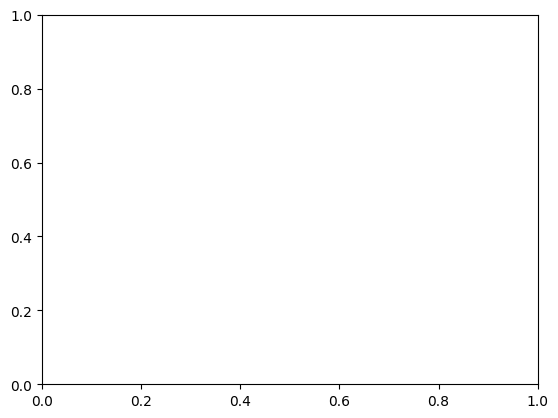

In [39]:
sigmas=[0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6,3.8]
plt.plot(sigmas,expsly)
plt.xlabel('sigma')
plt.ylabel('lambda')
plt.hlines(0,0,2.5,color='black')
plt.vlines(2.5,-0.02,0.01,color='green',label='sigma crit')
plt.vlines(np.sqrt(2),-0.02,0.01,color='red',label='sigma crit')
plt.legend()
plt.title('lyapunov exponent at time 700 for initial perturbation 0.001, S=800, Gaussian mu=-4')

(0.0, 1.5)

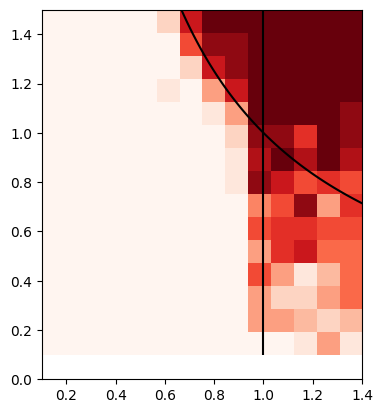

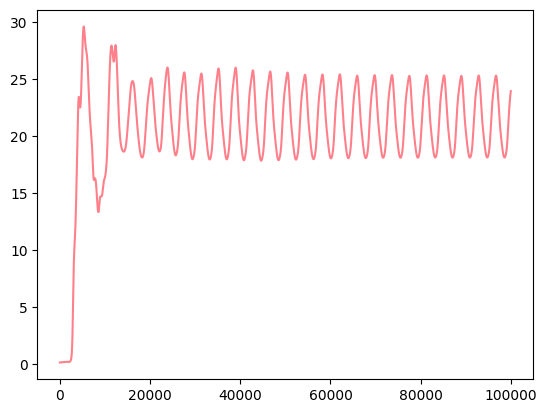

In [14]:
plt.plot(x[0].T[50],color=cmap(j),alpha=0.5)

In [ ]:
iterations = 50
M,C,traj =dmftsim(N,S,h,k,mu,sigma,iterations,tmax,dt,T)
#dmftsols = dmfts.evolve_dmft(50,250,0.1,0)
#normalsols = dmfts.evolve_ens(250,0.1,0)

In [ ]:
plt.plot(M)

In [ ]:
M = dmftsols[0]
cmap = plt.cm.get_cmap('hsv',dmfts.N)

for j in range(dmfts.N):
    plt.plot(np.sum(normalsols[j],axis=1)/dmfts.S,color=cmap(j),alpha=0.5)
plt.plot(M)
#plt.hlines(np.absolute(dmfts.sigma*dmfts.mu/(1-dmfts.mu)+1+dmfts.mu*M[-2]) ,xmin=0,xmax=200)
plt.hlines(0.714286,xmin=0,xmax=250,color='red')
plt.show()



In [ ]:
plt.hist(normalsols.transpose([1,0,2])[-1].flatten())
dmftsols[2]

In [ ]:
@jit()
def myfunc():
    b=np.zeros((N,N))
    np.fill_diagonal(b,0)

    for i in range(N):
        b[i][i] += 1
    return b

In [ ]:
a = quad(lambda x norm.pdf())